In [50]:

from bs4 import BeautifulSoup 
import string, unicodedata , contractions , json , re
from nltk.corpus import stopwords 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,GlobalAveragePooling1D
import numpy as np ; import matplotlib.pyplot as plt

In [23]:
STOPWORDS = stopwords.words("english")

**LOADING AND CLEANING DATA**

In [7]:
data  = []
with open("C:/codes/machineL/data/scarcasm/Sarcasm_Headlines_Dataset_v2.json","r") as f:
    for line in f:
        data.append(json.loads(line))

In [9]:
data[0]

{'is_sarcastic': 1,
 'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
 'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'}

In [24]:


def remove_html_tags(text):
    return BeautifulSoup(text,"html.parser").get_text()

def convert_unicode_data(text):
    return unicodedata.normalize("NFKD",text).encode("ascii","ignore").decode("utf-8","ignore")

def remove_urls(text):
    text =   re.sub('https?:\S*', ' ', text)
    text = re.sub('www?.\S*', ' ', text)
    return text 

def expand_contractions(text):
    expanded_words  = []

    for word in text :
        expanded_words.append(contractions.fix(word))
    return "".join(expanded_words)

def remove_mentions(text):
    text = re.sub(r'@\S*', ' ', text)
    text = re.sub(r'#\S*', ' ', text)
    return text

def removing_special_chars(text):
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat,' ',text)

def removing_numbers(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern,' ',text)

def remove_punctuation(text):
    return ''.join([c for c in text if c not in string.punctuation])



def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    text = convert_unicode_data(text)
    text = remove_urls(text)
    text = expand_contractions(text)
    text = remove_mentions(text)
    text = removing_numbers(text)
    text = remove_punctuation(text)
    text = " ".join(w for w in text.split() if w not in STOPWORDS)
    return text 

In [25]:
headlines = []
labels = []
for item in data :
    headlines.append(clean_text(item["headline"]))
    labels.append(item["is_sarcastic"])
    

In [67]:
train_size= 23000
last_size=  28000
training_data = headlines[0:train_size]
testing_data = headlines[train_size:last_size]
training_labels= np.array(labels[0:train_size])
testing_labels = np.array(labels[train_size:last_size])

In [32]:
training_data[:5]

['thirtysomething scientists younveil doomsday clock hair loss',
 'dem rep totally nails congress falling short gender racial eqyouality',
 'eat yoyour veggies delicioyously different recipes',
 'inclement weather prevents liar getting work',
 'mother comes pretty close yousing word streaming correctly']

In [76]:
num_words  = 20000 # vocab size also 
oov_token = "<OOV>"
pad_type = "post"
trunc_type="post"
embed_dim = 16


In [61]:
token = Tokenizer(num_words=num_words,oov_token=oov_token)
token.fit_on_texts(training_data)

In [68]:
train_data = token.texts_to_sequences(training_data)
train_data = pad_sequences(train_data,padding=pad_type,truncating=trunc_type)
train_data = np.array(train_data)

In [69]:
test_data = token.texts_to_sequences(testing_data)
test_data = pad_sequences(test_data,padding=pad_type,truncating=trunc_type)
test_data = np.array(test_data )

**Model Building**

In [81]:

model  = Sequential([
    Embedding(num_words,embed_dim),
    GlobalAveragePooling1D(),
    Dense(32,activation="relu"),
    Dense(1,activation="sigmoid")
    
])

In [82]:
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=["acc"])

In [89]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 110, 16)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_6           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 961,733 (3.67 MB)

 Trainable params: 320,577 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 641,156 (2.45 MB)

In [84]:
history =  model.fit(train_data,training_labels,validation_data=(test_data,testing_labels),epochs=10)

Epoch 1/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.5284 - loss: 0.6915 - val_acc: 0.6252 - val_loss: 0.6821
Epoch 2/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.5507 - loss: 0.6865 - val_acc: 0.7092 - val_loss: 0.5683
Epoch 3/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.7146 - loss: 0.6025 - val_acc: 0.7580 - val_loss: 0.5525
Epoch 4/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.7888 - loss: 0.4687 - val_acc: 0.7672 - val_loss: 0.6890
Epoch 5/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.8302 - loss: 0.3931 - val_acc: 0.7748 - val_loss: 0.7744
Epoch 6/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8588 - loss: 0.3405 - val_acc: 0.7860 - val_loss: 0.8197
Epoch 7/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8783 - loss: 0.3032 - val_acc: 0.7888 - val_loss: 0.8939
Epoch 8/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8833 - loss: 0.2824 - val_acc: 0.7918 - val_loss: 0.9386
Epoch 9/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - ac

In [85]:
loss,acc = model.evaluate(test_data,testing_labels)
acc

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7953 - loss: 0.9974


0.7954000234603882

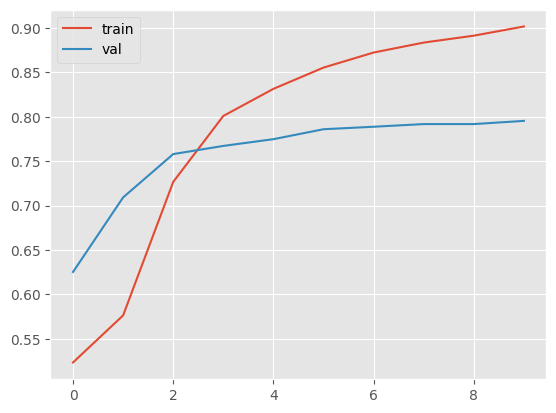

In [87]:
## Accuracy
plt.style.use("ggplot")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(["train","val"],loc='upper left')

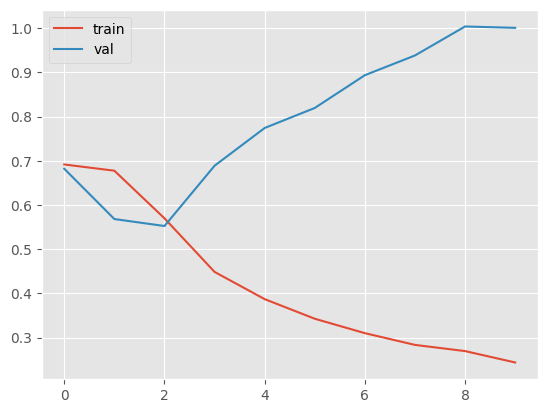

In [88]:
## Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["train", "val"],loc='upper left')

**Making Predictions**

In [93]:
sentences = ["granny starting to fear spiders in the garden might be real",
 "game of thrones season finale showing this sunday night",
 "TensorFlow book will be a best seller"]


In [94]:
def make_predictions(sents):
    sents = token.texts_to_sequences(sents)
    sents = pad_sequences(sents)
    return model.predict(sents)

In [95]:
make_predictions(sentences)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


array([[0.99999994],
       [1.        ],
       [0.01105639]], dtype=float32)

**towards 1 means its sarcastic**